In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
# import train data
data = pd.read_csv(r"C:\Users\kgeng\Desktop\train.csv")
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,0,1.01,Very Good,E,SI2,60.0,60.0,4540,6.57,6.49,3.92
1,1,1.10,Premium,H,VS2,62.5,58.0,5729,6.59,6.54,4.10
2,2,1.50,Good,E,SI2,61.5,65.0,6300,7.21,7.17,4.42
3,3,1.53,Premium,E,SI1,61.3,59.0,12968,7.40,7.35,4.52
4,4,0.84,Fair,D,SI2,64.5,60.0,2167,5.92,5.84,3.79


In [3]:
# take a look at train data shape
data.shape

(43154, 11)

In [4]:
# take a look at train data types and look for any missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43154 entries, 0 to 43153
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  43154 non-null  int64  
 1   carat       43154 non-null  float64
 2   cut         43154 non-null  object 
 3   color       43154 non-null  object 
 4   clarity     43154 non-null  object 
 5   depth       43154 non-null  float64
 6   table       43154 non-null  float64
 7   price       43154 non-null  int64  
 8   x           43154 non-null  float64
 9   y           43154 non-null  float64
 10  z           43154 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [5]:
# get rid of the column "Unnamed:0" since it is only counting entries
data = data.drop(["Unnamed: 0"], axis = 1)
data.describe()

,carat,depth,table,price,x,y,z
count,43154.000000,43154.000000,43154.000000,43154.000000,43154.000000,43154.000000,43154.000000
mean,0.799047,61.742925,57.459010,3946.777054,5.733798,5.737574,3.539338
std,0.475214,1.428410,2.227191,3998.657385,1.123004,1.150325,0.696203
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,953.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2406.500000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5367.000000,6.540000,6.540000,4.040000
max,4.500000,79.000000,79.000000,18823.000000,10.230000,58.900000,8.060000


In [6]:
# Drop data with size of 0 since a diamond size must be positive to make sense
data = data.drop(data[data["x"]==0].index)
data = data.drop(data[data["y"]==0].index)
data = data.drop(data[data["z"]==0].index)
data.shape

(43138, 10)

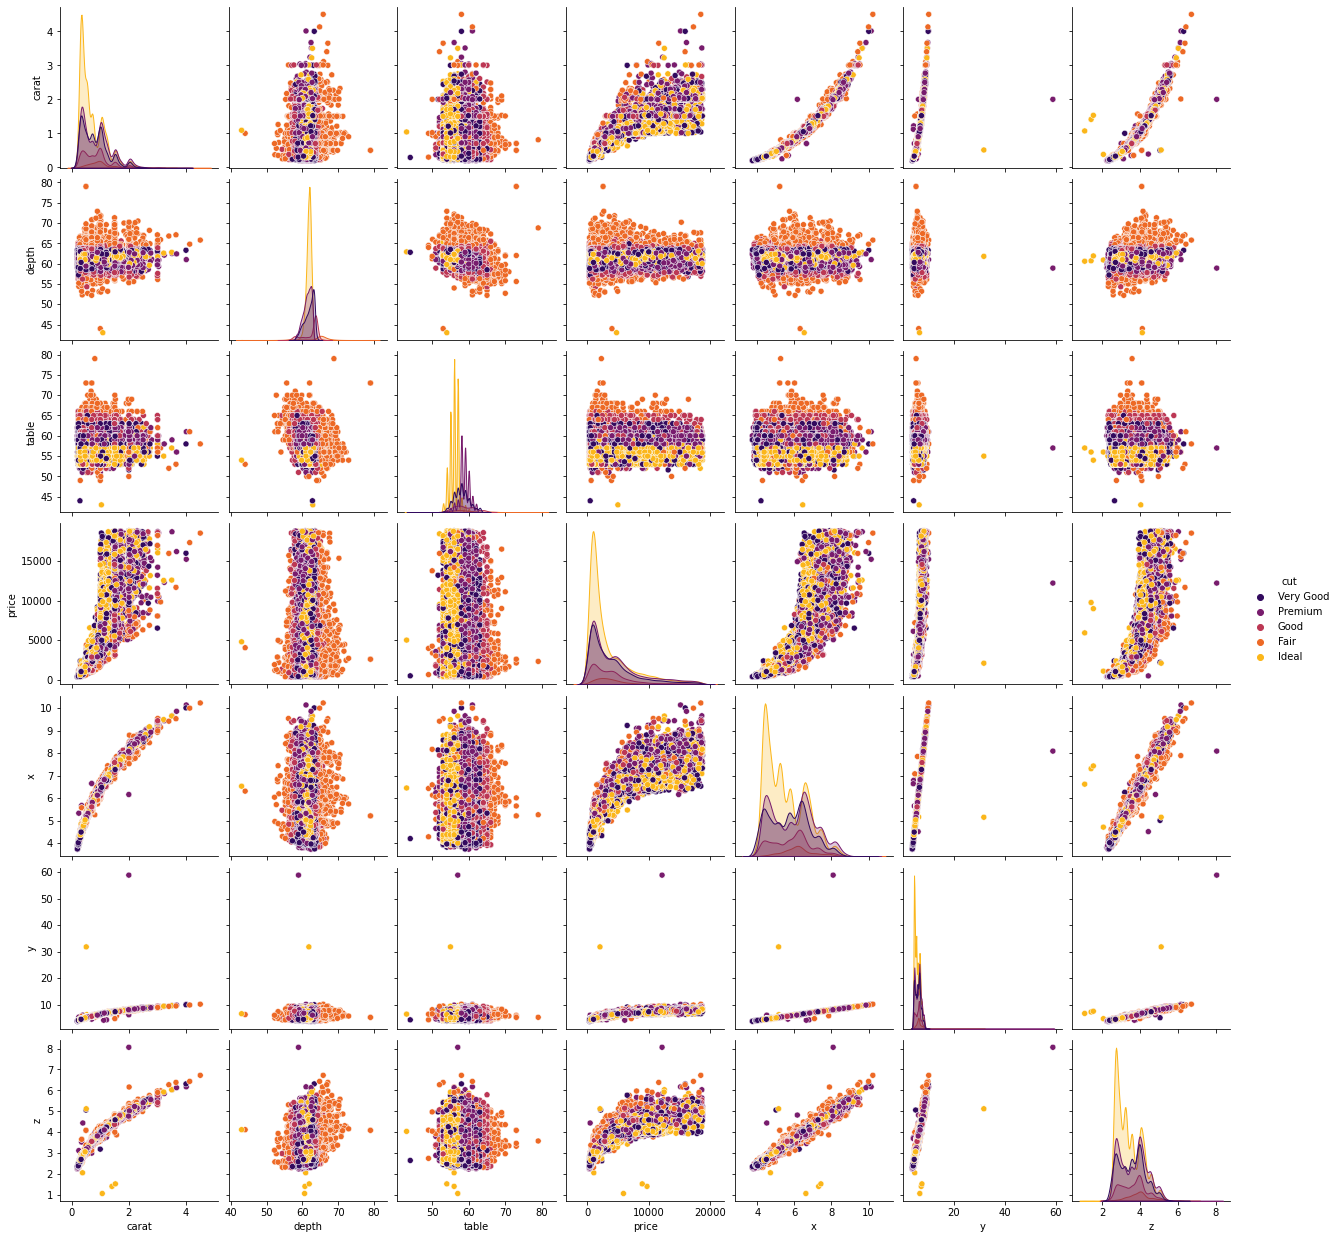

In [7]:
# making a pairplot to look for outliers and general shapes
ax = sns.pairplot(data, hue = "cut", palette = "inferno")

Text(0.5, 1.0, "Regression Line on Price vs 'x'")

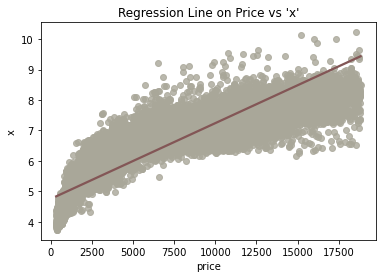

In [8]:
# make a separate plot for price vs x to take a closer look to the outliers
ax = sns.regplot(x="price", y="x", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws = {"color": "#835656"})
ax.set_title("Regression Line on Price vs 'x'")

Text(0.5, 1.0, "Regression Line on Price vs 'y'")

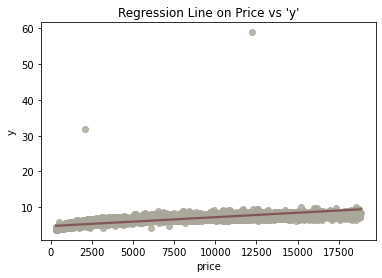

In [9]:
# individual plot for price vs y
ax = sns.regplot(x="price", y="y", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws = {"color": "#835656"})
ax.set_title("Regression Line on Price vs 'y'")

Text(0.5, 1.0, "Regression Line on Price vs 'z'")

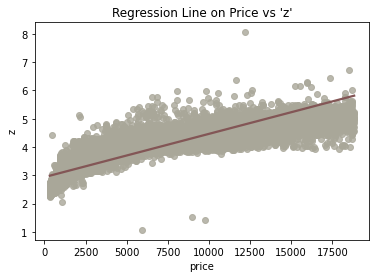

In [10]:
# individual plot for price vs z
ax = sns.regplot(x="price", y="z", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws = {"color": "#835656"})
ax.set_title("Regression Line on Price vs 'z'")

Text(0.5, 1.0, 'Regression Line on Price vs Depth')

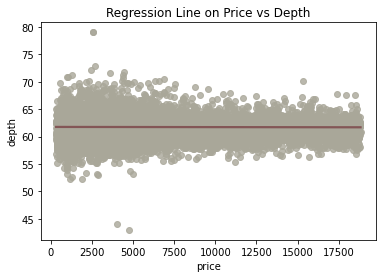

In [11]:
# individual plot for price vs depth
ax = sns.regplot(x="price", y="depth", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws = {"color": "#835656"})
ax.set_title("Regression Line on Price vs Depth")

Text(0.5, 1.0, 'Regression Line on Price vs Table')

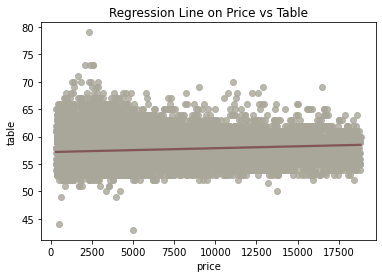

In [12]:
# individual plot for price vs table
ax = sns.regplot(x="price", y="table", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws = {"color": "#835656"})
ax.set_title("Regression Line on Price vs Table")

In [13]:
# get rid of outliers
data = data[(data["x"]<30)]
data = data[(data["y"]<20)]
data = data[(data["z"]<8)&(data["z"]>2)]
data = data[(data["depth"]<75)&(data["depth"]>45)]
data = data[(data["table"]<75)&(data["table"]>40)]
data.shape

(43128, 10)

In [14]:
# find categorical variables
s = (data.dtypes == "object")
obj_col = list(s[s].index)
print("Categorical variables:", obj_col)

Categorical variables: ['cut', 'color', 'clarity']


In [15]:
# make a copy of the data to proceed
copy_data = data.copy()

In [16]:
# apply label encoder to all columns for categorical data for train data
label_encoder = LabelEncoder()
for col in obj_col:
    copy_data[col] = label_encoder.fit_transform(copy_data[col])
copy_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.01,4,1,3,60.0,60.0,4540,6.57,6.49,3.92
1,1.10,3,4,5,62.5,58.0,5729,6.59,6.54,4.10
2,1.50,1,1,3,61.5,65.0,6300,7.21,7.17,4.42
3,1.53,3,1,2,61.3,59.0,12968,7.40,7.35,4.52
4,0.84,0,0,3,64.5,60.0,2167,5.92,5.84,3.79


In [17]:
data.describe()

,carat,depth,table,price,x,y,z
count,43128.000000,43128.000000,43128.000000,43128.000000,43128.000000,43128.000000,43128.000000
mean,0.798739,61.743111,57.458081,3944.476860,5.733927,5.735774,3.540609
std,0.475012,1.417644,2.222143,3996.518318,1.121143,1.112991,0.692417
min,0.200000,52.200000,43.000000,326.000000,3.730000,3.680000,2.060000
25%,0.400000,61.000000,56.000000,952.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2404.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5364.500000,6.540000,6.540000,4.040000
max,4.500000,72.900000,73.000000,18823.000000,10.230000,10.160000,6.720000


<AxesSubplot:>

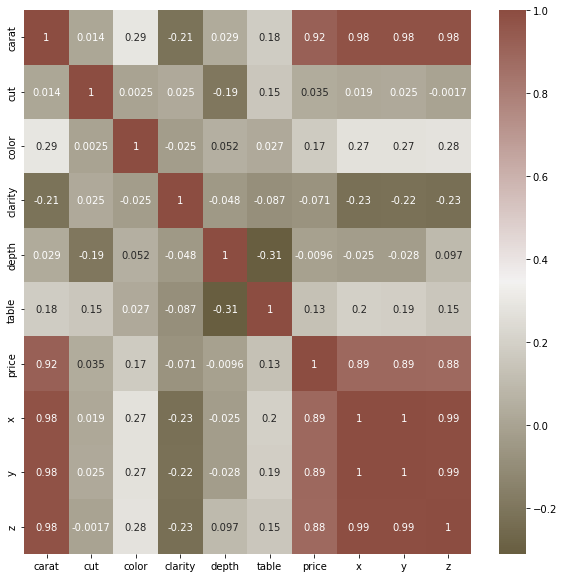

In [18]:
# create a heatmap to get a sense of correlations between variables
hmap = sns.diverging_palette(70,20,s=50,l=40,n=6, as_cmap = True)
correlation_matrix = copy_data.corr()
f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation_matrix, cmap = hmap,annot=True)

In [28]:
# TEST CYCLE ONLY
# in test cycle, split train data into 0.8 train data and 0.2 test data
X = copy_data.drop(["price"], axis = 1)
y = copy_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [33]:
# PRODUCTION CYCLE ONLY
# import test data
data_test = pd.read_csv(r"C:\Users\kgeng\Desktop\test.csv")
data_test.shape

(10789, 10)

In [34]:
# PRODUCTION CYCLE ONLY
data.describe()

,carat,depth,table,price,x,y,z
count,43128.000000,43128.000000,43128.000000,43128.000000,43128.000000,43128.000000,43128.000000
mean,0.798739,61.743111,57.458081,3944.476860,5.733927,5.735774,3.540609
std,0.475012,1.417644,2.222143,3996.518318,1.121143,1.112991,0.692417
min,0.200000,52.200000,43.000000,326.000000,3.730000,3.680000,2.060000
25%,0.400000,61.000000,56.000000,952.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2404.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5364.500000,6.540000,6.540000,4.040000
max,4.500000,72.900000,73.000000,18823.000000,10.230000,10.160000,6.720000


In [35]:
# PRODUCTION CYCLE ONLY
# find categorical data in test data
s_test = (data_test.dtypes == "object")
obj_test_col = list(s_test[s_test].index)
print("Categorical variables:", obj_test_col)

Categorical variables: ['cut', 'color', 'clarity']


In [36]:
# PRODUCTION CYCLE ONLY
# make a copy of the data to proceed
copy_data_test = data_test.copy()

# apply label encoder to all columns for categorical data for test data
label_encoder = LabelEncoder()
for col_t in obj_test_col:
    copy_data_test[col_t] = label_encoder.fit_transform(copy_data_test[col_t])
copy_data_test.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.24,2,3,6,62.1,56.0,3.97,4.00,2.47
1,1,1.21,4,2,5,62.9,54.0,6.78,6.82,4.28
2,2,0.50,0,1,2,61.7,68.0,5.09,5.03,3.12
3,3,0.50,2,0,3,62.8,56.0,5.06,5.03,3.17
4,4,1.55,2,1,3,62.3,55.0,7.44,7.37,4.61


In [37]:
# PRODUCTION CYCLE ONLY
# drop column "id" since it just seems to be a list of IDs
X_test = copy_data_test.drop(["id"], axis = 1)

In [38]:
# PRODUCTION CYCLE ONLY
# in application cycle, assgin features as X and target as y
X = copy_data.drop(["price"], axis = 1)
y = copy_data["price"]
X_train = X
y_train = y

In [39]:
# Build pipelines using standard scaler and and construct models using different types of regressors
# linear regression
pipe_linear = Pipeline([("scalar_1", StandardScaler()),
                       ("linear_classifier", LinearRegression())])
# decision tree
pipe_dtree = Pipeline([("scalar_2", StandardScaler()),
                       ("dtree_classifier", DecisionTreeRegressor())])
# random forest
pipe_rforest = Pipeline([("scalar_3", StandardScaler()),
                       ("rforest_classifier", RandomForestRegressor())])

lst_pipelines = [pipe_linear, pipe_dtree, pipe_rforest]


In [40]:
# fit the model using above pipelines
for pipe in lst_pipelines:
    pipe.fit(X_train, y_train)

In [31]:
# TEST CYCLE ONLY
# during test cycle, print out scores (RMSE) for the testset split from train data to validate the model
dct_pipelines = {0: "LinearRegression", 1:"DecisionTree",2:"RandomForest"}
for n,m in enumerate(lst_pipelines):
    score = cross_val_score(m, X_train, y_train, scoring = "neg_root_mean_squared_error")
    lst_score.append(score)
    print("%s: %f" % (dct_pipelines[n], -1*score.mean()))

LinearRegression: 1351.429263
DecisionTree: 767.494253
RandomForest: 554.434915


In [32]:
# PRODUCTION CYCLE ONLY
# save the model
filename = "diamond_model.sav"
pickle.dump(pipe_rforest,open(filename,"wb"))

In [41]:
# PRODUCTION CYCLE ONLY
# load model from disk and print predicted test results
loaded_model = pickle.load(open(filename,"rb"))
result = loaded_model.predict(X_test)
print(result)

[ 563.88 8497.67 1295.78 ... 1475.49 3929.68  785.5 ]


In [42]:
# PRODUCTION CYCLE ONLY
# save prediction in a csv file
data = {'Price': result}
df = pd.DataFrame(data, columns = ['Price'])
df.to_csv(r'newnewtestresult', index = False, header=True)